In [1]:
import data, model, loss, function
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
def print_content_feature_contrib(feature_activations_x, feature_activations_y):
    for key in feature_activations_x:
        feature_loss = torch.nn.functional.mse_loss(feature_activations_x[key], feature_activations_y[key])
        weight = 0.0
        if key in CONTENT_LOSS_WEIGHTS:
            weight = CONTENT_LOSS_WEIGHTS[key]
        weighted_loss = weight * feature_loss
        print("Content layer {} loss: {} weight: {} weighted loss: {}".format(key, feature_loss, weight, weighted_loss))

def print_style_feature_contrib(features_style, features_transformed):
    for key, weight in STYLE_LOSS_WEIGHTS.items():
        Gx = function.gram_matrix(features_style[key])
        Gy = function.gram_matrix(features_transformed[key])
        value = torch.nn.functional.mse_loss(Gx, Gy)
        weighted_value = weight * value
        print(f'Style loss {key} with weight {weight}: {value} weighted loss: {weighted_value}')

In [3]:
def forward(content, style, content_encoder, style_encoder, decoder):
    """ Forwards a batch through the pipeline.
    
    Parameters:
    -----------
    content : torch.Tensor, shape [B, C, H, W]
        The content image.
    style : torch.Tensor, shape [B, C, H', W']
        The style image, usually H' = H and W' = W.
    content_encoder : torch.nn.modules.Module
        Encoder for content images.
    style_encoder : torch.nn.modules.Module
        Encoder for style images.
    decoder : torch.nn.modules.Module
        Decoder that uses AdaIn to decode the content and apply the style.

    Returns:
    --------
    reco : torch.Tensor, shape [B, C, H, W]
        A reconstruction of the content after application of the style.
    style_representation : torch.Tensor, shape [B, D]
        The latent style representation.
    """
    content_representation = content_encoder(content)
    style_representation = style_encoder(style)
    transformed_content = function.adain(content_representation, style_representation)
    #reco = decoder(content_representation, style_representation)
    reco = decoder(content_representation)
    return reco, style_representation

In [ ]:
# Load training and validation dataset for style and content

VAL_PORTION = 0.1
ITERATIONS = 15002
VAL_ITERATIONS = 5
RESOLUTION = 128
STYLE_DIM = 2310
#STYLE_DIM = 38
BATCH_SIZE = 8
#CONTENT_LOSS_WEIGHTS = {'input' : 0.0, 'relu3' : 0.0, 'relu4' : 1e2, 'relu5' : 0.0}
#STYLE_LOSS_WEIGHTS = {'input' : 0.0, 'relu1' : 1e2, 'relu2' : 1e2, 'relu3' : 1e2, 'relu4' : 1e2, 'relu5' : 1e2}

CONTENT_LOSS_WEIGHTS = {
    'relu_4_2' : 1e-2,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e3,
    'relu_2_1' : 1e3,
    'relu_3_1' : 1e3,
    'relu_4_1' : 1e3,
    'relu_5_1' : 1e3,
}


data_style = data.load_debug_dataset('../dataset/style', resolution=RESOLUTION)
data_style_train, data_style_val = torch.utils.data.random_split(data_style, [len(data_style) - int(VAL_PORTION * len(data_style)), int(VAL_PORTION * len(data_style))])
data_loader_style_train = DataLoader(data_style_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_style_val = DataLoader(data_style_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

data_content = data.load_debug_dataset('../dataset/content', resolution=RESOLUTION)
data_content_train, data_content_val = torch.utils.data.random_split(data_content, [len(data_content) - int(VAL_PORTION * len(data_content)), int(VAL_PORTION * len(data_content))])
data_loader_content_train = DataLoader(data_content_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_content_val = DataLoader(data_content_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

data_loader_train = data.DatasetPairIterator(data_loader_content_train, data_loader_style_train)
data_loader_val = data.DatasetPairIterator(data_loader_content_val, data_loader_style_val)

content_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True, flattened_output_dim=STYLE_DIM)
style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#decoder = model.Decoder(STYLE_DIM)
decoder = model.Decoder()

loss_net = loss.LossNet()
loss_net.eval()

# Networks to CUDA device
if torch.cuda.is_available(): 
    content_encoder = content_encoder.cuda()
    style_encoder = style_encoder.cuda()
    decoder = decoder.cuda()
    loss_net = loss_net.cuda()

trainable_parameters = []
for parameter in content_encoder.parameters():
    trainable_parameters.append(parameter)
for parameter in style_encoder.parameters():
    trainable_parameters.append(parameter)
for parameter in decoder.parameters():
    trainable_parameters.append(parameter)


optimizer = torch.optim.Adam(trainable_parameters, lr=1e-6)


iteration = 0
running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0

content_loss_history_train = []
style_loss_history_train = []
content_loss_history_val = []
style_loss_history_val = []

for (content_image, content_path), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: break
    iteration += 1
    
    content_encoder.train()
    style_encoder.train()
    decoder.train()

    optimizer.zero_grad()
    if torch.cuda.is_available():
        content_image = content_image.to('cuda')
        style_image = style_image.to('cuda')

    #content_representation = content_encoder(content_image)
    #style_representation = style_encoder(style_image)

    #transformed_content = function.adain(content_representation, style_representation)
    #transformed = decoder(transformed_content)
    #transformed = decoder(content_representation, style_representation)
    
    transformed, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_transformed = loss_net(transformed)

    perceptual_loss = loss.perceptual_loss(features_content, features_transformed, CONTENT_LOSS_WEIGHTS)
    style_loss = loss.style_loss(features_style, features_transformed, STYLE_LOSS_WEIGHTS)
    
    lambda_content = 1.0
    lambda_style = 1.0

    total_loss = lambda_content * perceptual_loss + lambda_style * style_loss

    total_loss.backward()
    optimizer.step()

    running_perceptual_loss += perceptual_loss.item()
    running_style_loss += style_loss.item()

    running_count += 1

    print(f'\r{iteration:06d} : avg perceptual_loss : {running_perceptual_loss / running_count:.4f}\tavg style loss : {running_style_loss / running_count:.4f}', end='\r')
    content_loss_history_train.append(perceptual_loss.item())
    style_loss_history_train.append(style_loss.item())
    
    if iteration % 5000 == 1:
        torch.save(content_encoder.state_dict(), f'output/content_encoder_{iteration}')
        torch.save(style_encoder.state_dict(), f'output/style_encoder_{iteration}')
        torch.save(decoder.state_dict(), f'output/decoder_{iteration}')

    if iteration % 500 == 1:

        running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0 # After each validation, reset running training losses
        print(f'\nValidating...')

        content_encoder.eval()
        style_encoder.eval()
        decoder.eval()
        perceptual_loss = 0.0
        style_loss = 0.0
        val_iteration = 0

        with torch.no_grad():

            torch.save(content_image.cpu(), f'output/{iteration}_0_content.pt')
            torch.save(style_image.cpu(), f'output/{iteration}_0_style.pt')
            #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_0_style_reconstructed.pt')
            #torch.save(decoder(content_representation).cpu(), f'output/{iteration}_0_reconstructed.pt')
            torch.save(transformed.cpu(), f'output/{iteration}_0_transformed.pt')


            for (content_image, content_path), (style_image, style_path) in data_loader_val:
                val_iteration += 1
                if val_iteration > VAL_ITERATIONS: break

                if torch.cuda.is_available():
                    content_image = content_image.to('cuda')
                    style_image = style_image.to('cuda')

                #content_representation = content_encoder(content_image)
                #style_representation = style_encoder(style_image)

                #transformed_content = function.adain(content_representation, style_representation)
                #reconstruction = decoder(transformed_content)
                #reconstruction = decoder(content_representation, style_representation)
                
                reconstruction, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

                features_content = loss_net(content_image)
                features_style = loss_net(style_image)
                features_reconstruction = loss_net(reconstruction)
                
                print("------------------------------------------------------------------")
                print("Features content:")
                print_content_feature_contrib(features_content, features_reconstruction)
                print("Features style:")
                print_style_feature_contrib(features_style, features_reconstruction)
                print("------------------------------------------------------------------")
                
                perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
                style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)
                    
                torch.save(content_image.cpu(), f'output/{iteration}_{val_iteration}_content.pt')
                torch.save(style_image.cpu(), f'output/{iteration}_{val_iteration}_style.pt')
                torch.save(reconstruction.cpu(), f'output/{iteration}_{val_iteration}_reconstruction.pt')
                #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_{val_iteration}_style_reconstruction.pt')

                print(f'\rValidation {val_iteration:02d} : Perceptual loss {perceptual_loss / val_iteration:.4f}\tStyle loss {style_loss / val_iteration:.4f}', end='\r')
            print('\nValidation done.')
            val_iteration -= 1
            content_loss_history_val.append((iteration, perceptual_loss / val_iteration))
            style_loss_history_val.append((iteration, style_loss / val_iteration))

            torch.save(content_loss_history_train, 'output/content_loss_history_train.pt')
            torch.save(style_loss_history_train, 'output/style_loss_history_train.pt')
            torch.save(content_loss_history_val, 'output/content_loss_history_val.pt')
            torch.save(style_loss_history_val, 'output/style_loss_history_val.pt')
            

000001 : avg perceptual_loss : 0.1670	avg style loss : 1.2668
Validating...
------------------------------------------------------------------
Features content:
Content layer input loss: 1.7538347244262695 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.3633142113685608 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.7792928218841553 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.5180859565734863 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.458094358444214 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.207707405090332 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 17.38494110107422 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 14.956949234008789 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 19.677743911743164 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 25.300466537475586 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 24.856042861938477 weigh

------------------------------------------------------------------
Features content:
Content layer input loss: 1.2189768552780151 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.3830021321773529 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.8932775259017944 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.858712673187256 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.6500308513641357 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.036894798278809 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 17.147615432739258 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 14.920185089111328 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 19.865829467773438 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 26.031774520874023 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 25.9965877532959 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 65.00303649902344 wei

------------------------------------------------------------------
Features content:
Content layer input loss: 1.3448539972305298 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.4161292314529419 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.9753766059875488 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.685659408569336 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.4529802799224854 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 6.897748947143555 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 15.423107147216797 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 14.143440246582031 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 19.15540313720703 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 24.798742294311523 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 24.687652587890625 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 57.99390411376953 we

------------------------------------------------------------------
Features content:
Content layer input loss: 1.8740501403808594 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.3026788532733917 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.4598417282104492 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.504699468612671 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 2.6182100772857666 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 5.95805549621582 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 11.977137565612793 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 11.38208293914795 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 14.792770385742188 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 19.211687088012695 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 20.511350631713867 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 45.16184616088867 wei

------------------------------------------------------------------
Features content:
Content layer input loss: 2.1029067039489746 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.32356196641921997 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.4928419589996338 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.685681104660034 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 2.553699016571045 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 5.277708530426025 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 10.426466941833496 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 10.776497840881348 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 14.230391502380371 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 18.5804443359375 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 19.674869537353516 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 41.528602600097656 we

Validation 05 : Perceptual loss 0.1475	Style loss 0.3155
Validation done.
002001 : avg perceptual_loss : 0.1512	avg style loss : 0.4536
Validating...
------------------------------------------------------------------
Features content:
Content layer input loss: 2.448345422744751 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.3596426248550415 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.663947582244873 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.9498374462127686 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.069479465484619 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 6.766249656677246 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 13.377095222473145 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 12.4400634765625 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 15.82978630065918 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 20.25287628173828 weight: 0.0 wei

------------------------------------------------------------------
Features content:
Content layer input loss: 1.7508740425109863 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.2922247648239136 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.4584628343582153 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.62957763671875 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 2.692823886871338 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 5.88817834854126 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 11.676371574401855 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 10.908162117004395 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 13.851994514465332 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 17.95645523071289 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 19.511863708496094 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 42.12949752807617 weigh

------------------------------------------------------------------
Features content:
Content layer input loss: 2.128605604171753 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.41046205163002014 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.7382111549377441 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.92626953125 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.175917863845825 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.038752555847168 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 13.522854804992676 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 13.19456672668457 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 17.32839584350586 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 21.983123779296875 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 23.22418212890625 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 49.392982482910156 weight: 

------------------------------------------------------------------
Features content:
Content layer input loss: 1.5052781105041504 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.2996242046356201 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.4999468326568604 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.519665241241455 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 2.898289918899536 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 6.665011405944824 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 12.774279594421387 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 12.038012504577637 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 15.307723999023438 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 19.79148292541504 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 21.125688552856445 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 45.251304626464844 we

------------------------------------------------------------------
Features content:
Content layer input loss: 1.4226322174072266 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.3256746232509613 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.5270370244979858 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.5715689659118652 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.033302068710327 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 6.857365608215332 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 13.256064414978027 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 11.999691009521484 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 14.901762008666992 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 19.39385223388672 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 21.071067810058594 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 44.99065017700195 we

Validation 05 : Perceptual loss 0.1493	Style loss 0.3158
Validation done.
004001 : avg perceptual_loss : 0.1500	avg style loss : 0.4024
Validating...
------------------------------------------------------------------
Features content:
Content layer input loss: 1.8100703954696655 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.35716694593429565 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.6282641887664795 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.6330699920654297 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.2669291496276855 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.525218486785889 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 14.201990127563477 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 13.718283653259277 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 17.790983200073242 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 23.412757873535156 weight:

------------------------------------------------------------------
Features content:
Content layer input loss: 1.2449663877487183 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.4171329140663147 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 2.113156318664551 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.4864165782928467 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 4.074256896972656 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 9.36158275604248 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 17.868494033813477 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 16.094833374023438 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 20.214128494262695 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 26.069400787353516 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 28.203054428100586 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 60.283233642578125 we

F:\Programme\Miniconda3\envs\myenv\lib\site-packages\PIL\Image.py:2731: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


004501 : avg perceptual_loss : 0.1502	avg style loss : 0.3705
Validating...
------------------------------------------------------------------
Features content:
Content layer input loss: 1.5422025918960571 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.35338303446769714 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.7241290807724 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.8951072692871094 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.2784383296966553 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.28602409362793 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 14.029179573059082 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 12.28330135345459 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 15.097871780395508 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 19.30282974243164 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 20.460084915161133 weight: 

------------------------------------------------------------------
Features content:
Content layer input loss: 1.4655131101608276 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.407907098531723 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 2.117612600326538 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.3882110118865967 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.689535617828369 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 8.185892105102539 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 15.71627426147461 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 14.846920013427734 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 18.773452758789062 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 23.575899124145508 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 24.87788963317871 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 52.97639083862305 weigh

------------------------------------------------------------------
Features content:
Content layer input loss: 1.4215558767318726 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.29731717705726624 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.4515467882156372 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.3249783515930176 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 2.802140235900879 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 6.267355442047119 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 11.904727935791016 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 10.515052795410156 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 13.067682266235352 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 16.718589782714844 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 17.558006286621094 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 36.900474548339844

F:\Programme\Miniconda3\envs\myenv\lib\site-packages\PIL\Image.py:2731: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


005501 : avg perceptual_loss : 0.1483	avg style loss : 0.3911
Validating...
------------------------------------------------------------------
Features content:
Content layer input loss: 1.2894004583358765 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.3398807644844055 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.7576451301574707 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.7364914417266846 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.237086057662964 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.4088544845581055 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 14.081579208374023 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 12.878171920776367 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 16.492549896240234 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 20.71599578857422 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 21.73827362060547 weigh

------------------------------------------------------------------
Features content:
Content layer input loss: 2.0525732040405273 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.39172279834747314 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.7361793518066406 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.779914379119873 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.217042922973633 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.098352432250977 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 13.496156692504883 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 12.353860855102539 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 15.80997371673584 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 20.43442153930664 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 21.497575759887695 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 45.22764587402344 wei

------------------------------------------------------------------
Features content:
Content layer input loss: 1.5576776266098022 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.39284294843673706 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.9984028339385986 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.213045597076416 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 4.005676746368408 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 9.288578033447266 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 17.800777435302734 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 15.880224227905273 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 20.01095962524414 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 25.178428649902344 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 26.85525894165039 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 57.39117431640625 wei

------------------------------------------------------------------
Features content:
Content layer input loss: 1.5653454065322876 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.4160996377468109 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.947569489479065 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.104903221130371 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.5359153747558594 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.865906715393066 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 14.95637321472168 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 13.947612762451172 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 17.931472778320312 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 22.88384437561035 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 24.411333084106445 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 51.60272216796875 weig

------------------------------------------------------------------
Features content:
Content layer input loss: 1.1736747026443481 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.38436540961265564 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.888471245765686 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.141033172607422 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.614941358566284 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.820237159729004 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 14.976123809814453 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 13.497815132141113 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 17.211671829223633 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 21.79334259033203 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 22.440980911254883 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 46.957305908203125 we

Validation 05 : Perceptual loss 0.1250	Style loss 0.3523
Validation done.
007501 : avg perceptual_loss : 0.1485	avg style loss : 0.3676
Validating...
------------------------------------------------------------------
Features content:
Content layer input loss: 1.3173850774765015 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.3889809846878052 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.9091681241989136 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.0970921516418457 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.662395477294922 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 8.078771591186523 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 15.413711547851562 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 14.054342269897461 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 17.792194366455078 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 22.32807731628418 weight: 0.

------------------------------------------------------------------
Features content:
Content layer input loss: 1.6213184595108032 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.34876346588134766 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.6040912866592407 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.617037057876587 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.1170120239257812 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 6.836497783660889 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 12.923599243164062 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 12.194141387939453 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 15.860429763793945 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 20.432968139648438 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 21.712318420410156 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 44.2225341796875 w

------------------------------------------------------------------
Features content:
Content layer input loss: 1.6170657873153687 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.39722713828086853 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.9125313758850098 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.1470558643341064 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.619739294052124 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.757299423217773 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 14.86802864074707 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 13.080619812011719 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 16.576435089111328 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 20.733661651611328 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 21.531902313232422 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 44.56425476074219 w

------------------------------------------------------------------
Features content:
Content layer input loss: 1.5193077325820923 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.4215201735496521 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.8567065000534058 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.940462350845337 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.4797871112823486 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.651759624481201 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 14.630378723144531 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 12.955205917358398 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 16.37628936767578 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 21.045042037963867 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 22.10019302368164 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 46.38954162597656 wei

------------------------------------------------------------------
Features content:
Content layer input loss: 1.0309224128723145 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.37497881054878235 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.9549509286880493 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.2148168087005615 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.723534107208252 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 8.101236343383789 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 15.585988998413086 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 13.19360637664795 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 16.38668441772461 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 20.428871154785156 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 21.26776695251465 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 44.7815055847168 weig

Validation 05 : Perceptual loss 0.1371	Style loss 0.4080
Validation done.
009501 : avg perceptual_loss : 0.1429	avg style loss : 0.3594
Validating...
------------------------------------------------------------------
Features content:
Content layer input loss: 1.0449296236038208 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.3598731458187103 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.7821749448776245 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.902735710144043 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.3586974143981934 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.2636213302612305 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 13.905868530273438 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 12.091625213623047 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 15.102042198181152 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 19.07280731201172 weight: 0

------------------------------------------------------------------
Features content:
Content layer input loss: 1.2767330408096313 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.43925848603248596 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 2.095430374145508 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 3.3400626182556152 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 4.1151204109191895 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 9.092044830322266 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 17.123746871948242 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 15.893082618713379 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 20.42913246154785 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 25.672388076782227 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 26.519081115722656 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 55.84553146362305 w

------------------------------------------------------------------
Features content:
Content layer input loss: 1.2497297525405884 weight: 0.0 weighted loss: 0.0
Content layer relu_1_1 loss: 0.36466941237449646 weight: 0.0 weighted loss: 0.0
Content layer relu_1_2 loss: 1.833180546760559 weight: 0.0 weighted loss: 0.0
Content layer maxpool_1 loss: 2.9900572299957275 weight: 0.0 weighted loss: 0.0
Content layer relu_2_1 loss: 3.4519457817077637 weight: 0.0 weighted loss: 0.0
Content layer relu_2_2 loss: 7.441493988037109 weight: 0.0 weighted loss: 0.0
Content layer maxpool_2 loss: 14.15367317199707 weight: 0.0 weighted loss: 0.0
Content layer relu_3_1 loss: 12.410697937011719 weight: 0.0 weighted loss: 0.0
Content layer relu_3_2 loss: 15.326605796813965 weight: 0.0 weighted loss: 0.0
Content layer relu_3_3 loss: 19.57587242126465 weight: 0.0 weighted loss: 0.0
Content layer relu_3_4 loss: 20.04574966430664 weight: 0.0 weighted loss: 0.0
Content layer maxpool_3 loss: 41.58578872680664 wei

# Evaluate

In [11]:
CONTENT_LOSS_WEIGHTS = {
    'relu_4_2' : 5e-2,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e3,
    'relu_2_1' : 1e3,
    'relu_3_1' : 1e3,
    'relu_4_1' : 1e3,
    'relu_5_1' : 1e3,
}
RESOLUTION = 256
ITERATION = 5001
EVAL_ITERATIONS = 1
BATCH_SIZE = 1

data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
data_loader_style_eval = DataLoader(data_style, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_content = data.load_debug_dataset('../dataset/debug/content', resolution=RESOLUTION)
data_loader_content_eval = DataLoader(data_content, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_loader_eval = data.DatasetPairIterator(data_loader_content_eval, data_loader_style_eval)

content_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True, flattened_output_dim=STYLE_DIM)
style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#decoder = model.Decoder(STYLE_DIM)
decoder = model.Decoder()

content_encoder.load_state_dict(torch.load(f'output_train_places365_starry_night/content_encoder_{ITERATION}'))
style_encoder.load_state_dict(torch.load(f'output_train_places365_starry_night/style_encoder_{ITERATION}'))
decoder.load_state_dict(torch.load(f'output_train_places365_starry_night/decoder_{ITERATION}'))

loss_net = loss.LossNet()
loss_net.eval()

# Networks to CUDA device
if torch.cuda.is_available(): 
    content_encoder = content_encoder.cuda()
    style_encoder = style_encoder.cuda()
    decoder = decoder.cuda()
    loss_net = loss_net.cuda()

content_encoder.eval()
style_encoder.eval()
decoder.eval()

with torch.no_grad():
    eval_iteration = 0

    for (content_image, content_path), (style_image, style_path) in data_loader_eval:
        if eval_iteration >= EVAL_ITERATIONS:
            break

        perceptual_loss = 0.0
        style_loss = 0.0
        eval_iteration += 1

        if torch.cuda.is_available():
            content_image = content_image.to('cuda')
            style_image = style_image.to('cuda')

        #content_representation = content_encoder(content_image)
        #style_representation = style_encoder(style_image)

        #transformed_content = function.adain(content_representation, style_representation)
        #reconstruction = decoder(transformed_content)
        #reconstruction = decoder(content_representation, style_representation)

        reconstruction, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

        features_content = loss_net(content_image)
        features_style = loss_net(style_image)
        features_reconstruction = loss_net(reconstruction)

        perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
        style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)

        torch.save(content_image.cpu(), f'output/eval_{eval_iteration}_content.pt')
        torch.save(style_image.cpu(), f'output/eval_{eval_iteration}_style.pt')
        torch.save(reconstruction.cpu(), f'output/eval_{eval_iteration}_reconstruction.pt')

        print(f'Evaluation {eval_iteration:02d} : Perceptual loss {perceptual_loss:.4f}\tStyle loss {style_loss:.4f}')


Evaluation 01 : Perceptual loss 0.4050	Style loss 0.0529


# Other

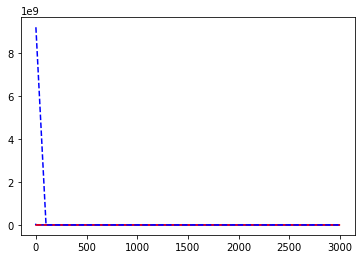

In [5]:
plt.plot(content_loss_history_train[10:], "r")
plt.plot(style_loss_history_train[10:], "b")
plt.plot(*zip(*content_loss_history_val), "r--")
plt.plot(*zip(*style_loss_history_val), "b--")

In [ ]:
image_batch = torch.load("./output/91_9_reconstruction.pt")
image_batch = data.vgg_normalization_undo(image_batch.numpy())
#plt.imshow(transforms.ToPILImage()(image))
image_batch = np.transpose(image_batch, (0, 2, 3, 1))
plt.imshow(image_batch[0])

In [ ]:
def show_images(epoch, iteration):
    content_batch = torch.load("./output/{}_{}_content.pt".format(epoch, iteration))
    style_batch = torch.load("./output/{}_{}_style.pt".format(epoch, iteration))
    reconstruction_batch = torch.load("./output/{}_{}_reconstruction.pt".format(epoch, iteration))
    
    content_batch = data.vgg_normalization_undo(content_batch.numpy())
    style_batch = data.vgg_normalization_undo(style_batch.numpy())
    reconstruction_batch = data.vgg_normalization_undo(reconstruction_batch.numpy())
    
    content_batch = np.transpose(content_batch, (0, 2, 3, 1))
    style_batch = np.transpose(style_batch, (0, 2, 3, 1))
    reconstruction_batch = np.transpose(reconstruction_batch, (0, 2, 3, 1))
    
    fig = plt.figure(figsize=(12, 4))
    
    fig.add_subplot(1, 3, 1)
    plt.imshow(content_batch[0])
    
    fig.add_subplot(1, 3, 2)
    plt.imshow(style_batch[0])
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(reconstruction_batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


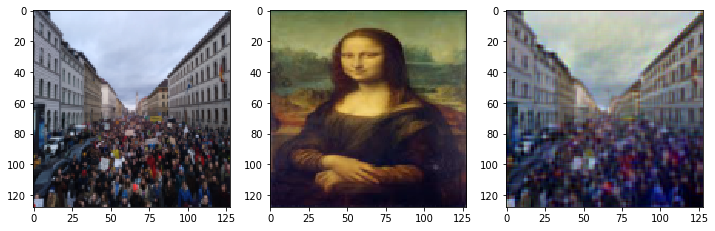

In [7]:
show_images(1101, 1)

In [16]:
print(STYLE_DIM)

2310
